# Worksheet 11: Beyond two-group comparisons

In [1]:
library(tidyverse)
library(infer)
library(datateachr)
library(testthat)
library(digest)
library(broom)
source("tests_worksheet_11.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘broom’ was b

## Learning Objectives

- Run a simple one-way ANOVA, without knowing the details of the test (the level of detail required is what's presented in the blog post).
- Calculate and interpret prediction intervals.

## Exercise 1: Recap Exercises

### Question 1.1

After how many hypotheses would we expect to make one Type I error, if each hypothesis is tested at a 0.05 significance level? Assuming the data from these tests are independent, that is. Put the number in a variable named `recap1`.

In [2]:
# recap1 <- FILL_THIS_IN

### BEGIN SOLUTION
recap1 <- 20
### END SOLUTION

print(recap1)

[1] 20


In [3]:
test_1.1()

success!

### Question 1.2

You decide to get some practice with data analysis, so you analyse a different data set each week. For each analysis, you produce a single 90% confidence interval for a parameter. After how many projects would you expect to have made a confidence interval that _does not_ contain the true parameter? Put your answer in a variable named `recap2`.

In [4]:
# recap2 <- FILL_THIS_IN

### BEGIN SOLUTION
recap2 <- 10
### END SOLUTION

print(recap2)

[1] 10


In [5]:
test_1.2()

success!

## Exercise 2: One-Way ANOVA

Consider the `attitude` dataset in the datasets R package, which provides the survey scores of six questions (along with an overall score) given to employees of an organization. A tidy version of the data without the overall score is stored below in the `attitudes_tidy` variable.

In [6]:
attitude_tidy <- 
    attitude %>% 
    select(-rating) %>% 
    pivot_longer(everything(), names_to = "question", values_to = "score")

head(attitude_tidy)

question,score
<chr>,<dbl>
complaints,51
privileges,30
learning,39
raises,61
critical,92
advance,45


A jitterplot + boxplot of the data is shown below:

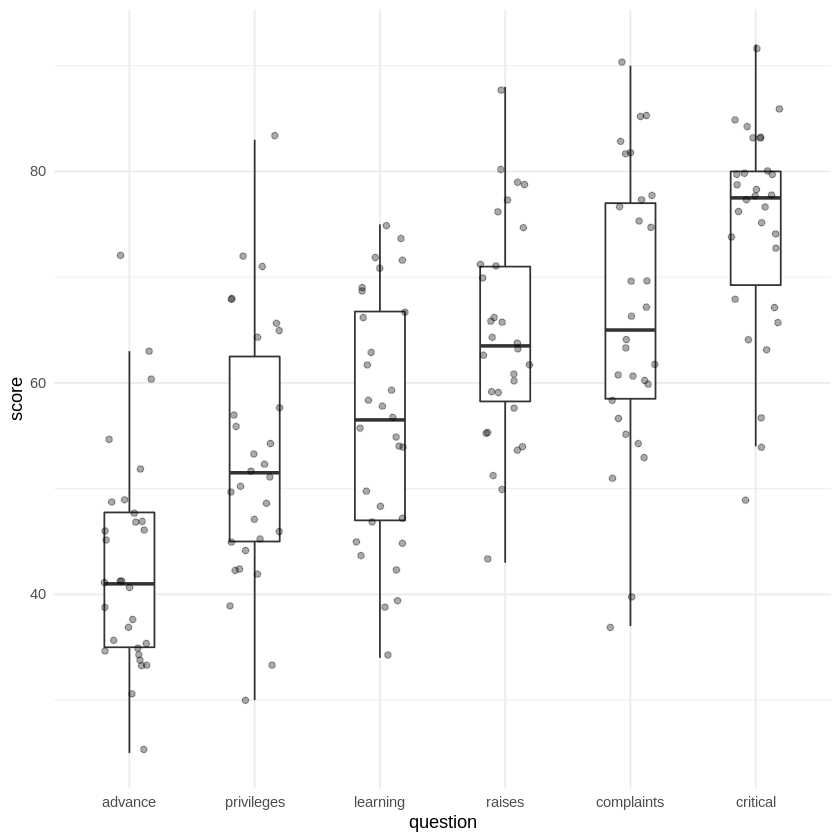

In [7]:
attitude_tidy %>% 
    mutate(question = question %>% 
                         as_factor() %>% 
                         fct_reorder(score)) %>% 
    ggplot(aes(question, score)) +
    geom_boxplot(width = 0.4, outlier.shape = NA) +
    geom_jitter(width = 0.2, alpha = 1 / 3) +
    theme_minimal()

Although there are visual differences between the groups, perhaps these differences are due to randomness.

For this exercise, denote $\mu_1, \mu_2, \ldots, \mu_6$ the means of each group (ordered as in the above plot).

### Question 2.1

Maybe the mean scores are actually the same for each question. How can we write this as a null hypothesis, using symbols? Place the letter to your answer in a variable named `null_hypothesis`.

**a**\. $\mu_1 = \mu_2 = \cdots = \mu_6$    
**b**\. There are actually 15 null hypotheses, one for each pair of means: $\mu_1 = \mu_2$, $\mu_1 = \mu_3$, $\mu_2 = \mu_3$, etc.     
**c**\. There is an upward trend in score across question type.

In [8]:
# null_hypothesis <- "FILL_THIS_IN"

### BEGIN SOLUTION
null_hypothesis <- "a"
### END SOLUTION

In [9]:
test_2.1()

success!

### Question 2.2

Make a tibble containing the variances for each question. Your tibble should have columns named `"question"`, containing the question, and `"variance"`, containing the variance calculated using the `var()`. There should be six rows -- one for each question. Store the tibble in a variable called `attitude_variances`.

In [10]:
# attitude_variances <- FILL_THIS_IN

### BEGIN SOLUTION
attitude_variances <- 
    attitude_tidy %>% 
    group_by(question) %>% 
    summarise(variance = var(score))
### END SOLUTION

attitude_variances

`summarise()` ungrouping output (override with `.groups` argument)



question,variance
<chr>,<dbl>
advance,105.8575
complaints,177.2828
critical,97.9092
learning,137.7575
privileges,149.7057
raises,108.1023


In [11]:
test_2.2()

success!

### Question 2.3

ANOVA performs more accurately if the variances within each group are the same. Judging by the observed variances, does this look like a decent approximation? Some resources say that, as long as the group with the highest variance isn't many multiples bigger than the smallest group variance, then the specified significance level will be roughly equal to the true significance level. Store either `"a"`, `"b"`, or `"c"` with the variable `variance_call` to indicate your response.

**a**\.  We can assume that the variances are equal.   
**b**\.  The difference in variances between groups is concerning.   
**c**\.  Each group having the same variance appears to be a decent approximation.

In [12]:
# variance_call <- "FILL_THIS_IN"

### BEGIN SOLUTION
variance_call <- "c"
### END SOLUTION

In [13]:
test_2.3()

success!

### Question 2.4

If the null hypothesis is true, then the overall variance could be calculated in two ways:

- The overall variance, as if the grouping variable was absent. Calculate this quantity, and store it in a variable named `variance_overall`
- The average group variance. Calculate this value by averaging the variances within each group. Store this number in a variable named `variance_group_avg`.

Note that there are other ANOVA methods that weigh group variances a different ways, to account for situations where groups have quite different variances.

A test statistic, then, would measure the discrepancy between these two values. Instead of calculating the difference, it works out better to calculate the _ratio_ of the overall variance to the average group variance. A big number (away from 1) is evidence that the null hypothesis may not be true. Store this ratio in a variable named `variance_ratio`.

Framework:

```r
variance_overall <- 
    attitude_tidy %>% 
    summarise(FILL_THIS_IN) %>% 
    pull(FILL_THIS_IN)
    
variance_group_avg <- attitude_variances %>% 
    summarise(FILL_THIS_IN) %>% 
    pull(FILL_THIS_IN)

variance_ratio <- FILL_THIS_IN
```

Your solution:

In [14]:
### BEGIN SOLUTION
variance_overall <- 
    attitude_tidy %>% 
    summarise(variance = var(score)) %>% 
    pull(variance)

variance_group_avg <- 
    attitude_variances %>% 
    summarise(variance = mean(variance)) %>% 
    pull(variance)

variance_ratio <- variance_overall / variance_group_avg
### END SOLUTION

print(variance_overall)
print(variance_group_avg)
print(variance_ratio)

[1] 232.127
[1] 129.4358
[1] 1.793375


In [15]:
test_2.4()

success!

### Question 2.5

The _actual_ test statistic -- called the ANOVA F-test statistic -- is a little different from the one we calculated. Its scale is adjusted, and is shifted so that its base is at 0. The interpretation is as a ratio of _treatment variance_ (variability of group means around the overall mean) to the within-group variance. Also, it turns out that this test statistic is well approximated by an _F_-distribution if the null hypothesis is true -- and is exactly true if each group's population is Normally distributed, and the group variances are exactly equal.

Use the `aov()` function to test the hypothesis. The relevant arguments are:

- First argument (`formula`): Takes the form `numeric_column_name ~ group_column_name`.
- `data`: Takes a data frame in tidy format (grouping column and numeric column).

Use the broom package's `tidy()` function to obtain the F-statistic and p-value. Store these values in the variables `f_stat` and `anova_pval`, respectively.

Framework:

```r
anova_results <- 
    aov(FILL_THIS_IN ~ FILL_THIS_IN, data = FILL_THIS_IN) %>% 
    tidy()
    
f_stat <- FILL_THIS_IN

anova_pval <- FILL_THIS_IN
```

In [16]:
### BEGIN SOLUTION
anova_results <- 
    aov(score ~ question, data = attitude_tidy) %>% 
    tidy()

f_stat <- anova_results$statistic[1]

anova_pval <- anova_results$p.value[1]
### END SOLUTION

print(anova_results)
print(f_stat)
print(anova_pval)

# A tibble: 2 x 6
  term         df  sumsq meansq statistic   p.value
  <chr>     <dbl>  <dbl>  <dbl>     <dbl>     <dbl>
1 question      5 19029.  3806.      29.4  1.43e-21
2 Residuals   174 22522.   129.      NA   NA       
[1] 29.40283
[1] 1.42922e-21


In [17]:
test_2.5()

success!

_Note_: You can also run an ANOVA by fitting linear models first, with `lm()`. But, this is a topic for STAT 301! 

### Question 2.6

What is our conclusion under a 0.01 significance level? Assign the letter response to a variable named `anova_conclusion`.

**a**\. Each group has a different / unique mean.   
**b**\. There's not enough evidence to suggest that the group means are different.   
**c**\. The group means are all equal.     
**d**\. At least one group has a mean that is significantly different from the others.   
**e**\. There is a positive linear relationship between score and question.

In [18]:
# anova_conclusion <- "FILL_THIS_IN"
### BEGIN SOLUTION
anova_conclusion <- "d"
### END SOLUTION

In [19]:
test_2.6()

success!

## Exercise 3: Prediction Intervals

Until now, we've been making inference on _population parameters_, such as means, quantiles, variances, etc. As we've seen, this inference allows us to present both (1) our best guess as to what the parameter is (an estimate), along with (2) a description of uncertainty (such as confidence intervals and hypothesis tests). But, 
how can we go about making inference on a _new observation_? 

In the tutorial, you'll explore predictions themselves. In this worksheet, we'll explore the inference part of predictions: _prediction intervals_.

To form a prediction interval, instead of using quantiles of the _(estimated) sampling distribution_, use the _population distribution_. 

Unlike sampling distributions, using the _true_ population distribution to form prediction intervals actually gives us prediction intervals with the specified probability. Using _true_ sampling distributions, on the other hand, is not useful for forming confidence intervals, because we know the true mean is in the center of the sampling distribution, so no interval at all is needed.

Since it's unusual to have access to the population distribution in practice, a common approach is to use the _sample distribution_ when forming prediction intervals. Doing so usually results in the true coverage probability to veer from the specified probability -- something we'll explore a little more in this exercise. 

### Question 3.1

Recall the City of Vancouver building permits dataset `building_permits` in the datateachr R package, which has building permit info on all buildings since 2017. Here is a tibble of the project values of all One-Family Dwellings (having non-zero value):

In [20]:
project_values <- 
    building_permits %>% 
    filter(specific_use_category == "One-Family Dwelling") %>% 
    select(project_value) %>% 
    filter(project_value > 0)

head(project_values)

project_value
<dbl>
35000
15000
4800
60000
15000
15000


<!-- For your own reference, here is a 95% *confidence* interval for the mean (Here, we'll take the population to be infinite: the value in today's dollars of all one-family dwellings since 2017, going on into the future. (Also assuming society remains similar to today's society.) -->
<!-- ) -->

<!-- ```{r} -->
<!-- project_values %>%  -->
<!--   rep_sample_n(size = nrow(.), replace = TRUE, reps = 1000) %>%  -->
<!--   group_by(replicate) %>%  -->
<!--   summarise(mean_value = mean(project_value), .groups = "drop") %>%  -->
<!--   pull(mean_value) %>%  -->
<!--   quantile(c(0.025, 0.975)) %>%  -->
<!--   unname() -->
<!-- ``` -->

If a new one-family dwelling is going to be built, what is a 90% prediction interval for this property's value (given that it's above 0)? Store this interval as a vector of length two (lower first, upper second), as a variable named `dwelling_pi`. 

Technicalities:

- Use the `quantile()` function (and its default `type = 7` argument).
- Ensure equal probability on both sides of the distribution. 

In [21]:
# dwelling_pi <- FILL_THIS_IN

### BEGIN SOLUTION
dwelling_pi <- 
    project_values %>% 
    pull(project_value) %>% 
    quantile(c(0.05, 0.95)) %>% 
    unname()
### END SOLUTION

print(dwelling_pi)

[1]    4500 1232919


In [22]:
test_3.1()

success!

### Question 3.2

Based on the definitions of prediction interval and confidence interval, what happens to these intervals as the sample size increases? Place the letters of your response in alphabetical order as a string, in a variable named `interval_trends`.

**a**\. Confidence intervals remain roughly the same width, because the confidence level remains the same.    
**b**\. Confidence intervals get narrower as we zero in on the true parameter.    
**c**\. Confidence intervals expand as we gain more and more confidence with larger sample sizes.   
**d**\. Prediction intervals remain roughly the same width -- after all, we're just getting better and better at estimating the true quantiles making up the boundaries of the prediction interval.   
**e**\. Prediction intervals get narrower as we zero in on the true future value.    
**f**\. Prediction intervals expand as we gain more and more confidence with larger sample sizes. 

In [23]:
# interval_trends <- "FILL_THIS_IN"

### BEGIN SOLUTION
interval_trends <- "bd"
### END SOLUTION

In [24]:
test_3.2()

success!

### Question 3.3

To build concepts, let's interpret our sample as being the entire population. What proportion of this population's property values fall in the prediction interval? This is called the _true coverage probability_, because it's the proportion of the population that truly falls in the interval. Take the interval to be inclusive of both endpoints. Store the proportion in a variable named `dwellings_in_pi`. 

(By the way: the reason you don't get 90% exactly is because the population is finite. This means that changing one of the endpoints of your prediction interval to the next higher or lower value will cause the confidence level to also make a discrete jump to another value. This is especially characteristic of discrete data.)

Framework:

```r
dwellings_in_pi <- 
    project_values %>% 
    summarise(prop = mean(
        between( ..., ..., ...)
    )) %>% 
    pull(FILL_THIS_IN)
```

Your solution:

In [25]:
# dwellings_in_pi <- FILL_THIS_IN
### BEGIN SOLUTION
dwellings_in_pi <- project_values %>% 
  summarise(prop = mean(
    project_value >= dwelling_pi[1] &
      project_value <= dwelling_pi[2]
  )) %>% 
  pull(prop)
### END SOLUTION
print(dwellings_in_pi)

[1] 0.9047917


In [26]:
test_3.3()

success!

### Question 3.4

Let's still interpret our sample as being the population, so that we can see an example of the specified coverage probability veering off from the true coverage probability. 

To see how the true coverage probabilities vary depending on the sample, let's take multiple (1000) samples of size 100, and calculate the true coverage probability for each of them. Remember, since our original sample is the entire population, it wouldn't make sense to sample with replacement, because we could potentially duplicate members of our population. Use a seed of `123`, and store your final vector of 1000 coverage probabilities in a vector named `coverage`. 

Scaffolding:

```r
set.seed(123)

## Draw 1000 samples of size 100:
sample_pi <- 
    project_values %>% 
    rep_sample_n(FILL_THIS_IN, replace = FILL_THIS_IN, reps = FILL_THIS_IN) %>% 
    group_by(replicate) %>% 
    summarise(lower = quantile(FILL_THIS_IN, FILL_THIS_IN),
              upper = quantile(FILL_THIS_IN, FILL_THIS_IN))

## Get vector of project values:
project_values_vec <- project_values$project_value

## Calculate coverage probabilities:
coverage <- 
    sample_pi %>% 
    group_by(replicate) %>% 
    summarise(coverage = mean(
    project_values_vec >= FILL_THIS_IN &
        FILL_THIS_IN
    )) %>% 
    pull(coverage)
```

Your solution:

In [27]:
# set.seed(123)
# FILL_THIS_IN
### BEGIN SOLUTION
set.seed(123)
sample_pi <- project_values %>% 
  rep_sample_n(100, replace = FALSE, reps = 1000) %>% 
  group_by(replicate) %>% 
  summarise(lower = quantile(project_value, 0.05),
            upper = quantile(project_value, 0.95))
project_values_vec <- project_values$project_value
coverage <- sample_pi %>% 
  group_by(replicate) %>% 
  summarise(coverage = mean(
    project_values_vec >= lower &
      project_values_vec <= upper
  )) %>% 
  pull(coverage)
### END SOLUTION
head(coverage)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 0.8841215 0.8910116 0.8643909 0.9185719 0.9035390 0.9242092

In [28]:
test_3.4()

success!

### Question 3.5

Here is a histogram of the coverage probabilities you produced, with a vertical line representing the intended coverage probability:

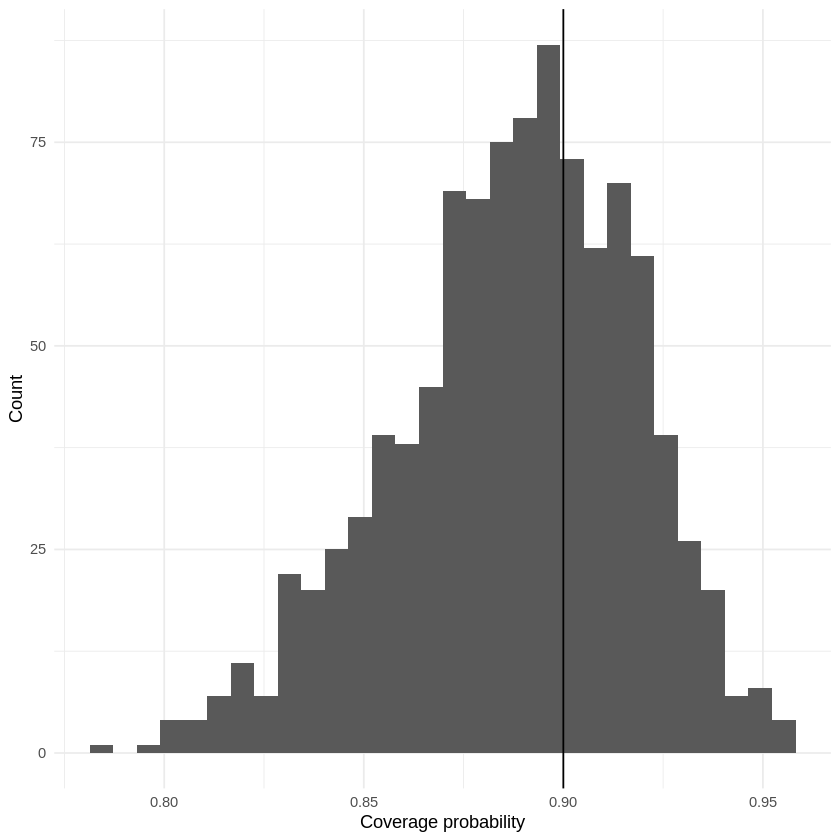

In [29]:
qplot(coverage, bins = 30) +
  theme_minimal() +
  xlab("Coverage probability") +
  ylab("Count") +
  geom_vline(xintercept = 0.9)

As you can see, the true coverage probability depends on the sample drawn. This histogram shape is typical, with more mass on the left, suggesting that smaller coverage probabilities are more likely.

Based on your simulation, just how likely are you to get a coverage probability less than the specified coverage probability of 0.9? Put this probability in a variable named `prob_smaller`.

In [30]:
# prob_smaller <- FILL_THIS_IN
### BEGIN SOLUTION
prob_smaller <- mean(coverage < 0.9)
### END SOLUTION
print(prob_smaller)

[1] 0.637


In [31]:
test_3.5()

success!

### Question 3.6

Now, consider our original population of one-family dwellings now and in the future. If it turns out that the true coverage probability of our prediction interval is smaller than the specified probability of 90%, what does this mean? Keep in mind that we can't know how the true coverage probability will compare. Place your selection(s) in alphabetical order in one string in a variable named `realities`.

**a**\. More one-family dwellings being built will have property values outside of our interval than we think.   
**b**\. Less one-family dwellings being built will have property values outside of our interval than we think.   
**c**\. In order to capture the true coverage probability, we would need to expand our prediction interval.   
**d**\. In order to capture the true coverage probability, we would need to shrink our prediction interval.   

Before we end this section, it's worth saying that there's still merit in using a sample-based prediction interval, even though the true coverage probability might be different from the specified one. Just as we have to accept error when estimating a parameter like the mean, we have to accept some level of error here, too. That being said, there *are* ways of adjusting prediction intervals to more closely match the true coverage probability. A famous one is when the population distribution is Gaussian (just google "prediction interval", and many resources will show a formula based on a Normal population). But, we won't cover these methods in this course. 

In [32]:
# realities <- "FILL_THIS_IN"

### BEGIN SOLUTION
realities <- "ac"
### END SOLUTION

In [33]:
test_3.6()

success!